In [55]:
import lightning.pytorch as pl
import numpy as np
import torch
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers.wandb import WandbLogger

from config import Config, load_config
from datasets import get_data
from models import get_model

In [2]:
# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [43]:
# initialize data attributes and loaders
%env BATCH_SIZE=128
%env DATASET_NAME=QPM_species
%env EMB_DIMS=128
%env MODEL_NAME=flow_mse
%env OOD=4

config = load_config()
config.load_data()
config.print_labels()
dm = config.datamodule
assert dm

env: BATCH_SIZE=128
env: DATASET_NAME=QPM_species
env: EMB_DIMS=128
env: MODEL_NAME=flow_mse
env: OOD=4


In [44]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species
Loaded 344518 images
Dataset type val label type: species
Loaded 44696 images
Dataset type test label type: species
Loaded 44924 images
Dataset type train label type: species
Loaded 30925 images
Dataset type val label type: species
Loaded 3866 images
Dataset type test label type: species
Loaded 3866 images


In [45]:
model = config.get_model()

In [46]:
# model id for each ood_k
model_ids = ['3qdutcy1', 'czgx4bod', '72y7x1fk', 'cqp59iho', 'fwur6c78']
model_id = model_ids[config.ood[0]]
print(model_id)

fwur6c78


In [47]:
from pathlib import Path
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robust_ml/model-{model_id}:best")
model = model.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [48]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
predict_loader = dm.predict_dataloader()

In [49]:
from models.common import edl_probs
from tqdm.auto import tqdm

ind_u_norms = []
ood_u_norms = []
rnd_u_norms = []

ind_v_norms = []
ood_v_norms = []
rnd_v_norms = []

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ind_u_norms.extend(u_norm.detach().cpu().numpy())
    ind_v_norms.extend(v_norm.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
for batch_idx, batch in enumerate(tqdm(predict_loader)):
    x, *_ = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    ood_u_norms.extend(u_norm.detach().cpu().numpy())
    ood_v_norms.extend(v_norm.detach().cpu().numpy())
print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    v, z, x_m, u_norm, v_norm, logits = model(x)
    rnd_u_norms.extend(u_norm.detach().cpu().numpy())
    rnd_v_norms.extend(v_norm.detach().cpu().numpy())
print("test RnD - OK")
    
ind_u_norms = np.array(ind_u_norms).squeeze()
ood_u_norms = np.array(ood_u_norms).squeeze()
rnd_u_norms = np.array(rnd_u_norms).squeeze()

ind_v_norms = np.array(ind_v_norms).squeeze()
ood_v_norms = np.array(ood_v_norms).squeeze()
rnd_v_norms = np.array(rnd_v_norms).squeeze()

print(ind_u_norms.shape, ind_v_norms.shape)
print(ood_u_norms.shape, ood_v_norms.shape)
print(rnd_u_norms.shape, rnd_v_norms.shape)

100%|██████████| 351/351 [00:12<00:00, 27.81it/s]


test InD - OK


100%|██████████| 303/303 [00:10<00:00, 27.79it/s]


test OoD - OK


100%|██████████| 100/100 [00:03<00:00, 32.33it/s]


test RnD - OK
(44924,) (44924,)
(38657,) (38657,)
(12800,) (12800,)


In [50]:
ind_u_norms_scaled = np.tanh(ind_u_norms)
ood_u_norms_scaled = np.tanh(ood_u_norms)
rnd_u_norms_scaled = np.tanh(rnd_u_norms)

print(ind_u_norms.mean(), ind_u_norms.std())
print(ood_u_norms.mean(), ood_u_norms.std())
print(rnd_u_norms.mean(), rnd_u_norms.std())

3.1924753 0.023858115
3.1517653 0.01418227
5.3840284 0.25251907


In [51]:
ind_v_norms_scaled = np.tanh(ind_v_norms)
ood_v_norms_scaled = np.tanh(ood_v_norms)
rnd_v_norms_scaled = np.tanh(rnd_v_norms)

print(ind_v_norms.mean(), ind_v_norms.std())
print(ood_v_norms.mean(), ood_v_norms.std())
print(rnd_v_norms.mean(), rnd_v_norms.std())

0.004757025 0.0019059401
0.0041335193 0.0115191
10.998397 0.34868997


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

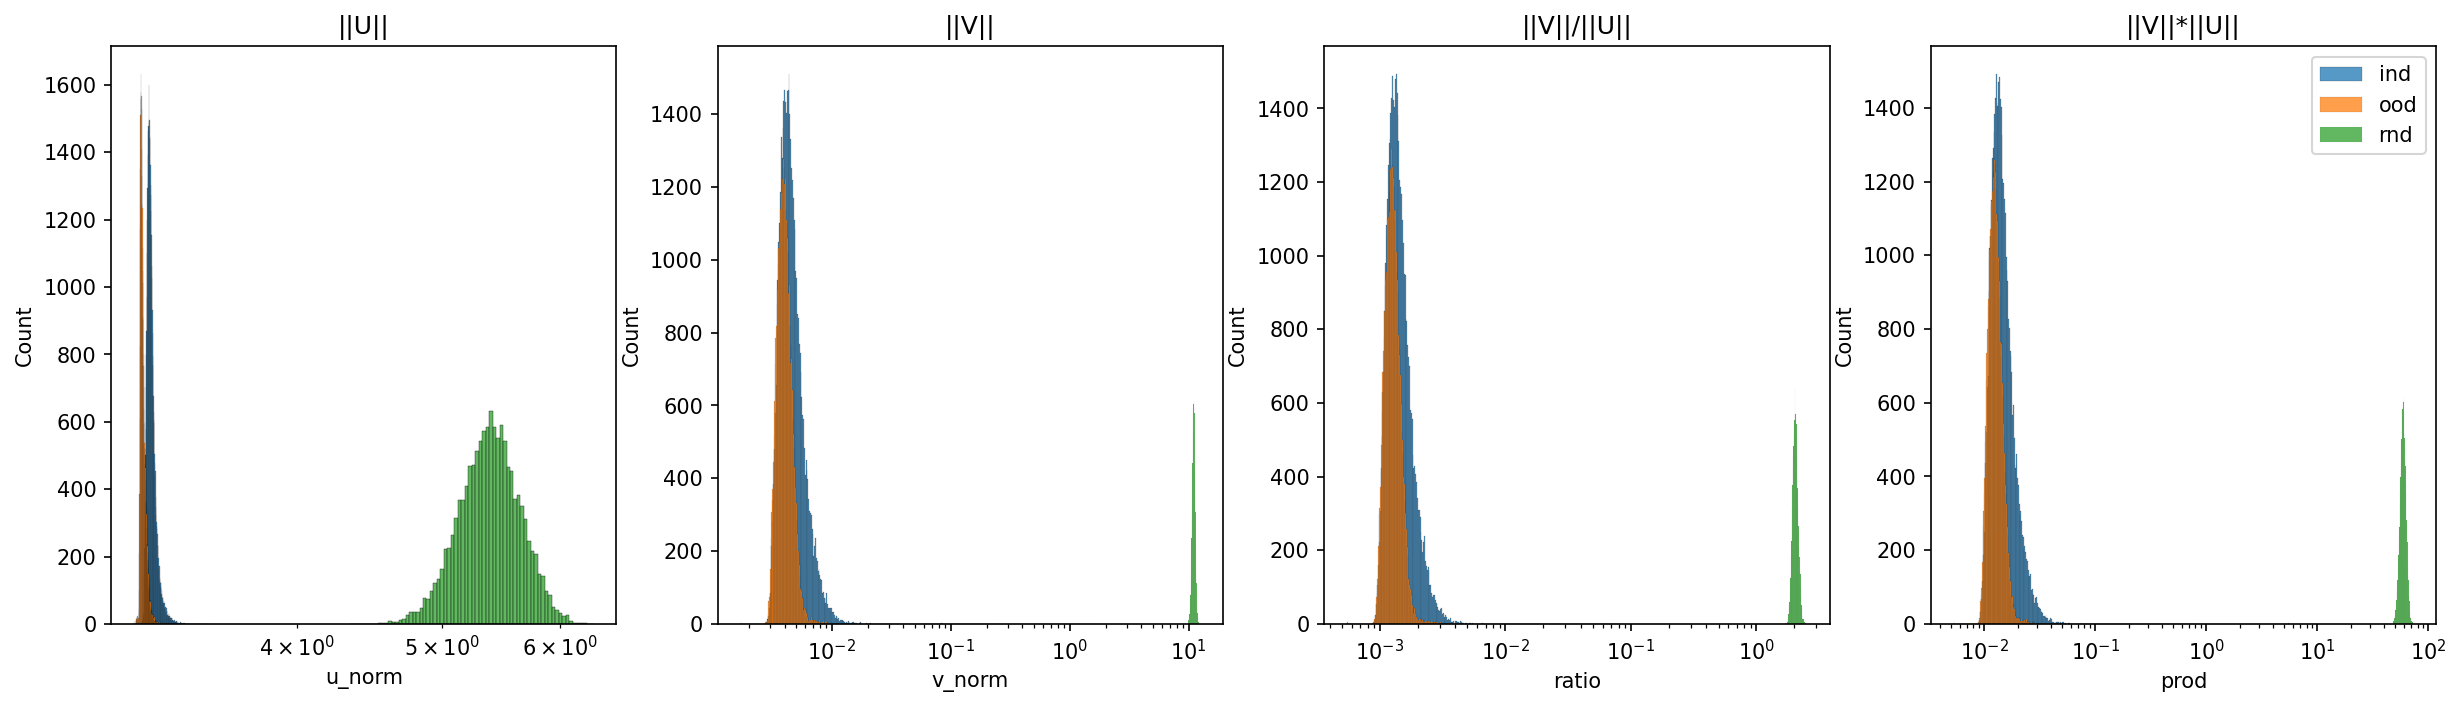

In [52]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 150

data_ind = pd.DataFrame(dict(u_norm=ind_u_norms, v_norm=ind_v_norms, ratio=ind_v_norms/ind_u_norms, prod=ind_v_norms*ind_u_norms))
data_ood = pd.DataFrame(dict(u_norm=ood_u_norms, v_norm=ood_v_norms, ratio=ood_v_norms/ood_u_norms, prod=ood_v_norms*ood_u_norms))
data_rnd = pd.DataFrame(dict(u_norm=rnd_u_norms, v_norm=rnd_v_norms, ratio=rnd_v_norms/rnd_u_norms, prod=rnd_v_norms*rnd_u_norms))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20, 5))

sns.histplot(data=data_ind, x="u_norm", log_scale=True, fill=True, label='ind', ax=ax1)
sns.histplot(data=data_ood, x="u_norm", log_scale=True, fill=True, label='ood', ax=ax1)
sns.histplot(data=data_rnd, x="u_norm", log_scale=True, fill=True, label='rnd', ax=ax1)

sns.histplot(data=data_ind, x="v_norm", log_scale=True, fill=True, label='ind', ax=ax2)
sns.histplot(data=data_ood, x="v_norm", log_scale=True, fill=True, label='ood', ax=ax2)
sns.histplot(data=data_rnd, x="v_norm", log_scale=True, fill=True, label='rnd', ax=ax2)

sns.histplot(data=data_ind, x="ratio", log_scale=True, fill=True, label='ind', ax=ax3)
sns.histplot(data=data_ood, x="ratio", log_scale=True, fill=True, label='ood', ax=ax3)
sns.histplot(data=data_rnd, x="ratio", log_scale=True, fill=True, label='rnd', ax=ax3)

sns.histplot(data=data_ind, x="prod", log_scale=True, fill=True, label='ind', ax=ax4)
sns.histplot(data=data_ood, x="prod", log_scale=True, fill=True, label='ood', ax=ax4)
sns.histplot(data=data_rnd, x="prod", log_scale=True, fill=True, label='rnd', ax=ax4)

ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.legend()
plt.savefig(f"assets/figures/qpm_species_flow_mse_M128_ood_u_{config.ood[0]}.png")

In [78]:
x = torch.randn(32, 48, 4, 4)

ts = (x.shape[0], *[1]*(len(x.shape)-1))
x_norm = x.flatten(1).norm(dim=1).view(x.shape[0], *[1]*len(s[1:]))

print(x.shape, x_norm.shape)

torch.Size([32, 48, 4, 4]) torch.Size([32, 1, 1, 1])
